In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

Base = automap_base()

Base.prepare(engine, reflect=True)

In [6]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
#saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#creating session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Retrieving dates
session.query(Measurement.date).order_by(Measurement.date.desc()).first() #result is '2017-08-23'

year_ago = dt.datetime(2017,8,22) - dt.timedelta(weeks=52) #result is '2016-8-23'
print(year_ago)

2016-08-23 00:00:00


In [11]:
#query1
last12 = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > year_ago).\
                filter(Measurement.prcp.isnot(None)).all()


q1date = []
q1prcp = []

for d,p in last12:  
    q1date.append(d)
    q1prcp.append(p)

        
q1_df = pd.DataFrame({'Date': q1date, 'Precipitation': q1prcp})
q1_df.set_index('Date', inplace=True)
q1_df.sort_values(by=['Date'])
q1_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


<IPython.core.display.Javascript object>


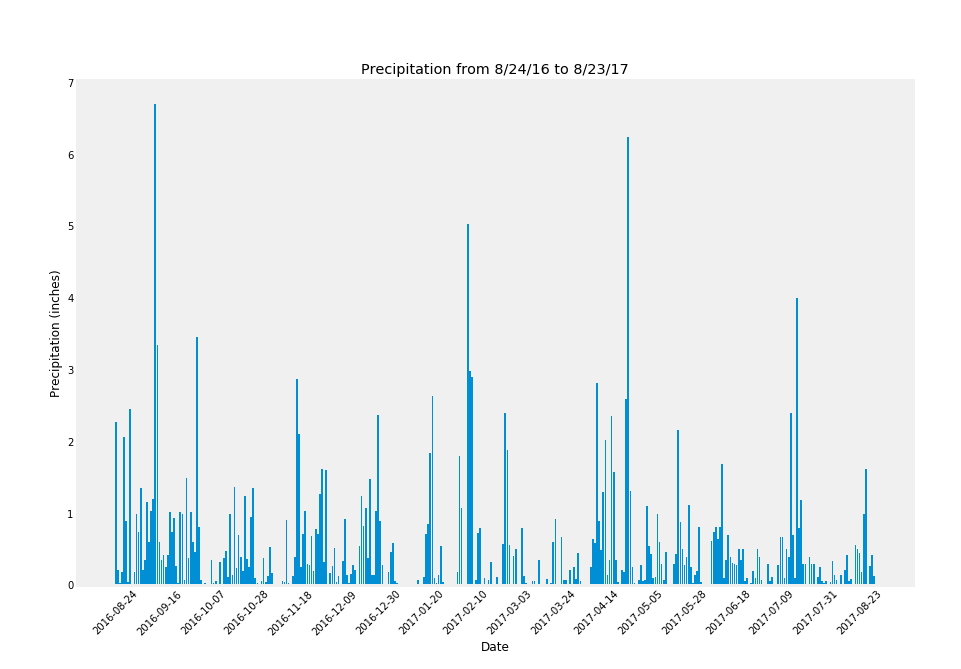

In [14]:
%matplotlib notebook

plt.bar(q1_df.index, q1_df['Precipitation'])

plt.title('Precipitation from 8/24/16 to 8/23/17')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.grid(b=False)

#Found this solution online for tick suppression: stackoverflow.com/questions/20337664
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::21]))
for label in temp:
    label.set_visible(False)
    
    
plt.savefig('Figures/Precipitation.png', bbox_inches='tight')
plt.show()

In [12]:
#summary statistics for the precipitation data
q1_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
#Total number of stations
stations = session.query(Station.station).count()

print(f'There are {stations} total stations')

There are 9 total stations


In [14]:
#Most active stations listed in descending order of count
#Wasn't sure how to print without paranthesis
most_active = session.query(func.count(Measurement.station), Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

for row in most_active:
    print(row)

(2772, 'USC00519281')
(2724, 'USC00519397')
(2709, 'USC00513117')
(2669, 'USC00519523')
(2612, 'USC00516128')
(2202, 'USC00514830')
(1979, 'USC00511918')
(1372, 'USC00517948')
(511, 'USC00518838')


In [15]:
#Most active station temperatures
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]


station_temps = session.query(*sel).filter(Measurement.station=='USC00519281').all()

print(f'''Most Active Station (ID): {station_temps[0][0]}
Lowest Temp: {station_temps[0][1]}˚F
Highest Temp: {station_temps[0][2]}˚F
Average Temp: {round(station_temps[0][3], 1)}˚F
''')

Most Active Station (ID): USC00519281
Lowest Temp: 54.0˚F
Highest Temp: 85.0˚F
Average Temp: 71.7˚F



In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

count_tobs = session.query(func.count(Measurement.tobs), Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs)).all()

count_tobs

[(511, 'USC00518838'),
 (1372, 'USC00517948'),
 (1979, 'USC00511918'),
 (2202, 'USC00514830'),
 (2612, 'USC00516128'),
 (2669, 'USC00519523'),
 (2709, 'USC00513117'),
 (2724, 'USC00519397'),
 (2772, 'USC00519281')]

In [17]:
tobs_last12 = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.date > year_ago).\
                    filter(Measurement.station == 'USC00519281').all()

tobs_x = []
tobs_y = []

for x,y in tobs_last12:
    if y == None:
        y == ''
    else:    
        tobs_x.append(x)
        tobs_y.append(y)

        
%matplotlib notebook
        
tobs_df = pd.DataFrame({'Date': tobs_x, 'Temperature': tobs_y})
tobs_df.set_index('Date', inplace=True)
tobs_df.sort_values(by=['Date'])
tobs_df.head()

,Temperature
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


<IPython.core.display.Javascript object>


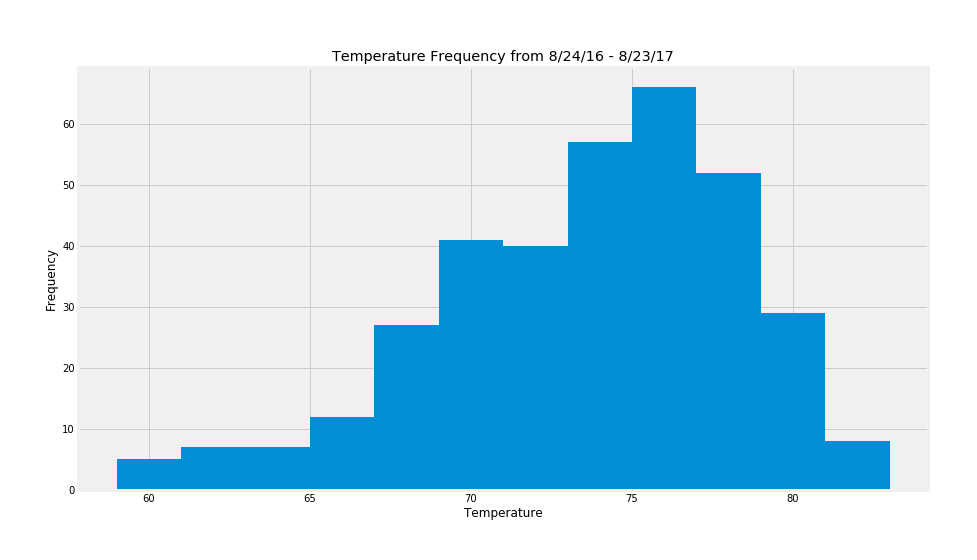

In [64]:
tobs_df.plot(kind='hist', title='Temperature Frequency from 8/24/16 - 8/23/17', legend=None, bins=12)
plt.xlabel('Temperature')
plt.savefig('Figures/histogram.png', bbox_inches='tight')

NO BONUS OBJECTIVES COMPLETED